<a href="https://colab.research.google.com/github/2020vkarthik/AI_Medical_Tutor/blob/main/SemanticEvaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install rouge-score nltk bert-score sacrebleu

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   

In [2]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from bert_score import score

def evaluate_mcq(model_answer, gold_answer):
    return model_answer.strip().lower() == gold_answer.strip().lower()

def evaluate_explanation(model_explanation, gold_explanation):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_score = scorer.score(model_explanation, gold_explanation)['rougeL'].fmeasure
    bleu_score = sentence_bleu([gold_explanation.split()], model_explanation.split())
    P, R, F1 = score([model_explanation], [gold_explanation], lang="en")
    return {
        "ROUGE-L": rouge_score,
        "BLEU": bleu_score,
        "BERTScore": F1.tolist()[0]
    }

def evaluate_case_based(model_answer, gold_answer):
    P, R, F1 = score([model_answer], [gold_answer], lang="en")
    return {"BERTScore": F1.tolist()[0]}

def evaluate_short_answer(model_answer, gold_answer):
    return evaluate_explanation(model_answer, gold_answer)

# Gold Standard Responses
gold_standard = {
    "MCQ1": {"answer": "D", "explanation": "Dehydration reduces fluid levels in the body, leading to decreased urine output as the kidneys try to conserve water."},
    "MCQ2": {"answer": "B", "explanation": "Diarrhea leads to excessive water and electrolyte loss through stool, causing dehydration."},
    "Case1": "Dehydration due to decreased fluid intake or increased fluid loss.",
    "Case2": "Administer oral rehydration therapy (ORT) with a solution containing electrolytes and carbohydrates.",
    "Short1": "Dehydration disrupts electrolyte balance by increasing sodium concentration in the blood, which can lead to cellular dysfunction and organ impairment.",
    "Short2": "Lack of vasopressin (ADH), which causes excessive water loss through increased urine production."
}

# Model Responses
model_responses = {
    "Model1": {
        "MCQ1": {"answer": "D", "explanation": "Dehydration can lead to decreased urine output due to insufficient fluid intake."},
        "Case1": "Dehydration due to decreased fluid intake or increased fluid loss.",
        "Short1": "Dehydration can disrupt the body's electrolyte balance by causing an imbalance in the concentration of water and electrolytes in the body, leading to changes in the function of cells and organs."
    },
    "Model2": {
        "MCQ2": {"answer": "B", "explanation": "In patients with diarrhea, the gut lining is damaged, leading to increased permeability and loss of electrolytes and water into the stool. As a result, the body tries to compensate by increasing urine production to eliminate excess sodium and water, leading to dehydration."},
        "Case2": "Administer oral rehydration therapy (ORT) with a solution containing electrolytes and carbohydrates.",
        "Short2": "Increased urine production due to the absence of vasopressin (ADH), leading to excessive water loss in the urine."
    }
}

# Evaluation
results = {}
for model, responses in model_responses.items():
    results[model] = {}
    for qid, response in responses.items():
        if isinstance(response, dict):  # MCQ type
            correctness = evaluate_mcq(response["answer"], gold_standard[qid]["answer"])
            explanation_scores = evaluate_explanation(response["explanation"], gold_standard[qid]["explanation"])
            results[model][qid] = {"Correct": correctness, "Explanation Scores": explanation_scores}
        else:  # Case-based or short answer
            if "Case" in qid:
                results[model][qid] = evaluate_case_based(response, gold_standard[qid])
            else:
                results[model][qid] = evaluate_short_answer(response, gold_standard[qid])

# Print Results
import json
print(json.dumps(results, indent=4))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how m

{
    "Model1": {
        "MCQ1": {
            "Correct": true,
            "Explanation Scores": {
                "ROUGE-L": 0.4516129032258065,
                "BLEU": 0.13607231222827057,
                "BERTScore": 0.9318062663078308
            }
        },
        "Case1": {
            "BERTScore": 1.0000001192092896
        },
        "Short1": {
            "ROUGE-L": 0.4615384615384615,
            "BLEU": 2.2304689656310324e-78,
            "BERTScore": 0.9390308856964111
        }
    },
    "Model2": {
        "MCQ2": {
            "Correct": true,
            "Explanation Scores": {
                "ROUGE-L": 0.2545454545454546,
                "BLEU": 1.0638581151575014e-231,
                "BERTScore": 0.8989063501358032
            }
        },
        "Case2": {
            "BERTScore": 0.9999999403953552
        },
        "Short2": {
            "ROUGE-L": 0.45161290322580644,
            "BLEU": 3.9941352076225525e-78,
            "BERTScore": 0.936627686023712

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You sho

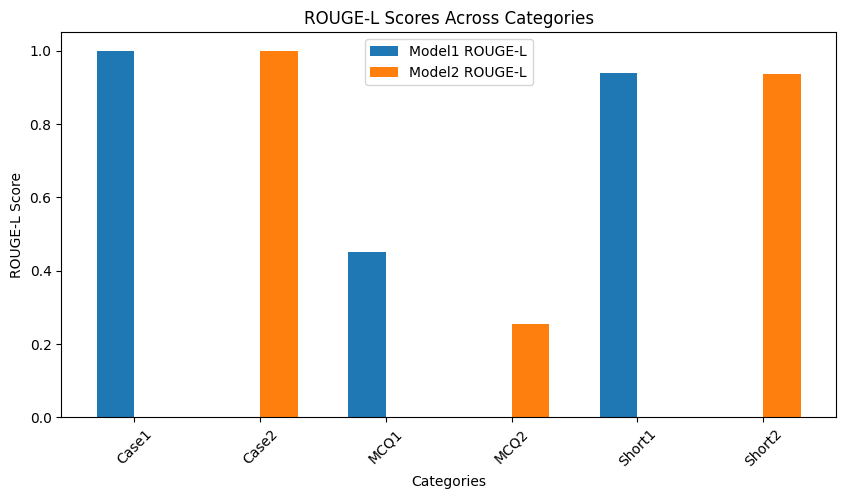

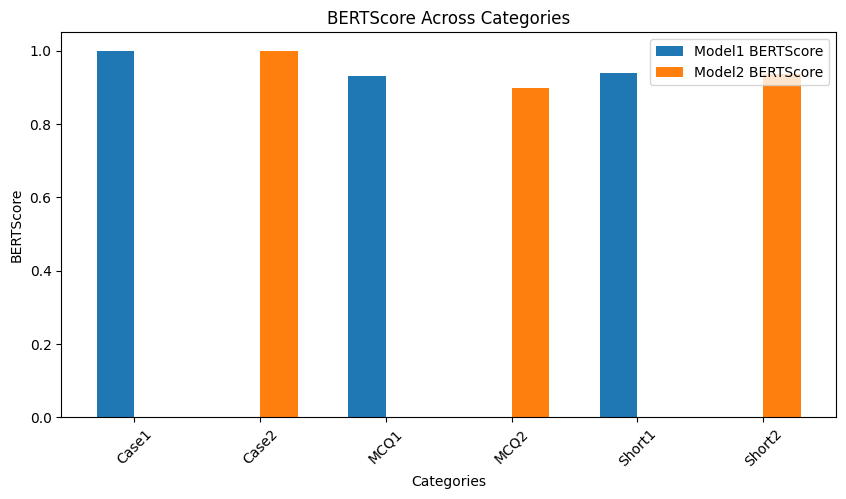

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from rouge_score import rouge_scorer
from bert_score import score

# Evaluation Functions
def evaluate_mcq(model_answer, gold_answer):
    return model_answer.strip().lower() == gold_answer.strip().lower()

def evaluate_explanation(model_explanation, gold_explanation):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_score = scorer.score(model_explanation, gold_explanation)['rougeL'].fmeasure
    P, R, F1 = score([model_explanation], [gold_explanation], lang="en")
    return {
        "ROUGE-L": rouge_score,
        "BERTScore": F1.tolist()[0]
    }

def evaluate_case_based(model_answer, gold_answer):
    P, R, F1 = score([model_answer], [gold_answer], lang="en")
    return {"BERTScore": F1.tolist()[0]}

def evaluate_short_answer(model_answer, gold_answer):
    return evaluate_explanation(model_answer, gold_answer)

# Gold Standard Responses
gold_standard = {
    "MCQ1": {"answer": "D", "explanation": "Dehydration reduces fluid levels in the body, leading to decreased urine output as the kidneys try to conserve water."},
    "MCQ2": {"answer": "B", "explanation": "Diarrhea leads to excessive water and electrolyte loss through stool, causing dehydration."},
    "Case1": "Dehydration due to decreased fluid intake or increased fluid loss.",
    "Case2": "Administer oral rehydration therapy (ORT) with a solution containing electrolytes and carbohydrates.",
    "Short1": "Dehydration disrupts electrolyte balance by increasing sodium concentration in the blood, which can lead to cellular dysfunction and organ impairment.",
    "Short2": "Lack of vasopressin (ADH), which causes excessive water loss through increased urine production."
}

# Model Responses
model_responses = {
    "Model1": {
        "MCQ1": {"answer": "D", "explanation": "Dehydration can lead to decreased urine output due to insufficient fluid intake."},
        "Case1": "Dehydration due to decreased fluid intake or increased fluid loss.",
        "Short1": "Dehydration can disrupt the body's electrolyte balance by causing an imbalance in the concentration of water and electrolytes in the body, leading to changes in the function of cells and organs."
    },
    "Model2": {
        "MCQ2": {"answer": "B", "explanation": "In patients with diarrhea, the gut lining is damaged, leading to increased permeability and loss of electrolytes and water into the stool. As a result, the body tries to compensate by increasing urine production to eliminate excess sodium and water, leading to dehydration."},
        "Case2": "Administer oral rehydration therapy (ORT) with a solution containing electrolytes and carbohydrates.",
        "Short2": "Increased urine production due to the absence of vasopressin (ADH), leading to excessive water loss in the urine."
    }
}

# Evaluation
results = {}
for model, responses in model_responses.items():
    results[model] = {}
    for qid, response in responses.items():
        if isinstance(response, dict):  # MCQ type
            correctness = evaluate_mcq(response["answer"], gold_standard[qid]["answer"])
            explanation_scores = evaluate_explanation(response["explanation"], gold_standard[qid]["explanation"])
            results[model][qid] = {"Correct": correctness, "Explanation Scores": explanation_scores}
        else:  # Case-based or short answer
            if "Case" in qid:
                results[model][qid] = evaluate_case_based(response, gold_standard[qid])
            else:
                results[model][qid] = evaluate_short_answer(response, gold_standard[qid])

# Extracting Scores for Visualization
categories = sorted(set(qid for model in results.values() for qid in model))
models = list(results.keys())

# Fix shape mismatch by ensuring all categories have values for all models
rouge_scores = {
    model: [
        results[model].get(cat, {}).get("Explanation Scores", {}).get("ROUGE-L", 0) or
        results[model].get(cat, {}).get("BERTScore", 0)  # Default to 0 if missing
        for cat in categories
    ]
    for model in models
}

bert_scores = {
    model: [
        results[model].get(cat, {}).get("Explanation Scores", {}).get("BERTScore", 0) or
        results[model].get(cat, {}).get("BERTScore", 0)  # Default to 0 if missing
        for cat in categories
    ]
    for model in models
}

x = np.arange(len(categories))
bar_width = 0.3

# Plot ROUGE-L Scores
plt.figure(figsize=(10, 5))
for i, model in enumerate(models):
    plt.bar(x + i * bar_width, rouge_scores[model], width=bar_width, label=f"{model} ROUGE-L")

plt.xlabel("Categories")
plt.ylabel("ROUGE-L Score")
plt.title("ROUGE-L Scores Across Categories")
plt.xticks(x + bar_width / 2, categories, rotation=45)
plt.legend()
plt.show()

# Plot BERT Scores
plt.figure(figsize=(10, 5))
for i, model in enumerate(models):
    plt.bar(x + i * bar_width, bert_scores[model], width=bar_width, label=f"{model} BERTScore")

plt.xlabel("Categories")
plt.ylabel("BERTScore")
plt.title("BERTScore Across Categories")
plt.xticks(x + bar_width / 2, categories, rotation=45)
plt.legend()
plt.show()
